# KKBox Cleaning and Feature Engineering

In this notebook, we build off of the EDA ananlysis from the previous notebook. Our preliminary exploration of the datasets provided by KKBox have given us a sense of which features might be important in predicting the churn rate, as well as which features are not (especially ones containing many missing values that cannot be replaced). 

---

## Table of Contents

### Cleaning

- Train and Test Datasets Cleaning
- Members
- Merging Members to `train_df`
- Transactions
- User Logs

### Feature Engineering

- Transactions Feature Engineering
- Merging Transactions to `train_df` with New Features
- User Logs Feature Engineering
- Merging User Logs to `train_df` with New Features

### Merged Dataset Further Clean up

- Missing Values
- Date Conversions
- Merged Dataset `train_df` final Feature Engineering: Last Log Day
- Date Splitting 
- Feature Selection
- Feature Encoding

### Correlation
- Correlation Heatmap
- Pairplot

### Saving and Exporting Final Clean Data
- Preserving clean data to pickle for use in future notebooks

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### Train and Test Datasets Cleaning

**Train**

In [2]:
#Reading in given train dataset csv file
train_df = pd.read_csv('data/train_v2.csv')

**Target Variable: `is_churn`**

In [ ]:
train_df.head()

In [4]:
train_df.shape

(970960, 2)

In [5]:
# check the number of duplicate rows in each table
train_df.duplicated('msno').sum()

0

There are no duplicate rows in the given train dataset. Let's check how our target variable is split.

In [6]:
#Determine number of no churn entries in train dataset
(train_df['is_churn']==0).sum()

883630

In [7]:
#Determine number of churn entries in train dataset
(train_df['is_churn']==1).sum()

87330

The given `train` dataset is highly imbalanced. After we merge the other tables and select our final features, we will have to apply a method to fix this imbalance. Let's check the test set to determine if we can use it or if we need to split our given train into a new train and test. 

**Test**

In [8]:
#Reading in given train dataset csv file
test_df = pd.read_csv('data/sample_submission_v2.csv')

In [9]:
test_df.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [10]:
test_df.duplicated('msno').sum()

0

In [11]:
(test_df['is_churn']==0).sum()

907471

In [12]:
(test_df['is_churn']==1).sum()

0

Since the given test set has no values for users who churn, we cannot use this for testing predictions. Instead we will have to split our final merged dataframe into validation and test sets as well as investigate sampling techniques to deal with the churn imbalance in our train dataframe. 

---

### Members

In [13]:
members_df= pd.read_csv('data/members_v3.csv')


In [14]:
members_df.shape

(6769473, 6)

In [15]:
members_df.duplicated('msno').sum()

0

There are no duplicate rows in the members dataset. Let's check if there are any missing values.

In [16]:
#Checkin for null values
members_df.isna().sum()

msno                            0
city                            0
bd                              0
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

The `gender` column is the only feature that has duplicate values. We can either fill these null values with unknown or drop. Since most of the rows don't have gender data, we should be safe to drop gender as it won't provide much value to our model. 

In [17]:
members_new= members_df.drop(columns =['gender'])

---

### Merging Members

We begin by merging `members` into our train dataframe.

In [18]:
# merge members into train 
train_df = train_df.merge(members_new, on = 'msno', how = 'left')

In [19]:
train_df.head()

,msno,is_churn,city,bd,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,7.0,20140125.0


In [20]:
train_df.isna().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
registered_via            109993
registration_init_time    109993
dtype: int64

We will stick to replacing the null values in `city` and `registered_via` with the mode. 

In [22]:
# This function uses mode to replace NaN values on train_df
def replacemode(i):
    train_df[i] = train_df[i].fillna(train_df[i].value_counts().index[0])
    return 

replacemode('city')
replacemode('registered_via')

In [23]:
train_df.isna().sum()

msno                           0
is_churn                       0
city                           0
bd                        109993
registered_via                 0
registration_init_time    109993
dtype: int64

As we have previously seen in the EDA notebook, `bd` also has missing values and outliers.We saw that replacing them with the median age of 20 forced too many datapoints into one age. Instead, we will just drop `bd` all together 

In [25]:
train_df= train_df.drop(columns =['bd'])

We convert the float features `city` and `registered_via` to int.

In [26]:
# change the data type of city, registered_via from float to int 
train_df['city'] = train_df['city'].astype(int)
train_df['registered_via'] = train_df['registered_via'].astype(int)

In [27]:
train_df.shape

(970960, 5)

### Transactions

In [28]:
transaction_v2_df = pd.read_csv('data/transactions_v2.csv')

In [29]:
transaction_v2_df.shape

(1431009, 9)

In [30]:
transaction_v2_df.duplicated('msno').sum()

233959

In [31]:
transactions_v1_df = pd.read_csv('data/transactions.csv')

In [32]:
transactions_v1_df.shape

(21547746, 9)

In [33]:
transactions_v1_df.duplicated('msno').sum()

19184120

We can merge the transactions datasets together to have all transactions from 2015-2017 in one dataframe.

In [34]:
transactions_df =  transactions_v1_df.append(transaction_v2_df)


/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/ipykernel_56047/2376265263.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_df =  transactions_v1_df.append(transaction_v2_df)


In [35]:
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [36]:
transactions_df.index = range(len(transactions_df))


In [37]:
# sort transactions and add calculated values in new columns
temp_trans = transactions_df.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)

In [38]:
# drop duplicates from transactions
temp_trans = temp_trans.drop_duplicates(subset=['msno'], keep='first')

---

### User Logs

In [39]:
# Reading in user logs dataframe (just for 2017, since the other file with all of the years is 25 GB!)
user_logs_df = pd.read_csv('data/user_logs_v2.csv')

In [40]:
user_logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [41]:
user_logs_df.shape

(18396362, 9)

User Logs has 18,396,362 rows and 9 columns.

In [42]:
#Checking for duplicate rows
user_logs_df.duplicated('msno').sum()

17292468

There are 17,292,468 duplicate rows in the user logs dataframe.

In [43]:
# remove duplicates from user logs
user_logs_df=user_logs_df.drop_duplicates(subset=['msno'], keep='first')

In [44]:
user_logs_df.shape

(1103894, 9)

After dropping the duplicate rows, the user logs dataframe now has 1,103,894 rows.

---

## Feature Engineering

#### Transactions Feature Engineering

From the transactions dataset, we can engineer our own features that will provide us with more interesting and interpretable reasons as to why a customer might churn. 

 ***discount***  
 How much discount was offered to the customer.
 
 ***is_discount***    
 To check whether the customer was offered a discount.
 
 ***amt_per_day***   
 A new column featuring the amount paid per-day.
 
 ***membership_days***    
  The difference between **transaction_date** and	**membership_expire_date** would give us membership duration.
 We calculate the difference between these two columns in terms of days and store the result as type integer.

Motivation: We have information on whether users auto-renewed and cancelled, but we do not have explicit infomation about certain combinations.  
***autorenew_&_not_cancel***

A binary feature to see whether members have **auto renewed** and **not cancelled** at the same time:
* **auto_renew** = 1 and
* **is_cancel** = 0

***notAutorenew_&_cancel***
A binary feature to predict possible churning if members have **auto renewed** and **cancelled** at the same time:
* **auto_renew** = 0 and
* **is_cancel** = 1

We generate these new features:

In [45]:
#Discount formula
temp_trans['discount'] = temp_trans['plan_list_price'] - temp_trans['actual_amount_paid']

In [46]:
# Is discount
temp_trans['is_discount'] = temp_trans.discount.apply(lambda x: 1 if x > 0 else 0)

In [47]:
# Amount paid per day
temp_trans['amt_per_day'] = temp_trans['actual_amount_paid'] / temp_trans['payment_plan_days']

In [48]:
# Membership Duration
temp_trans['membership_days']= temp_trans['membership_expire_date'] - temp_trans['transaction_date']

In [49]:
#Auto_Renew and Not Cancel
temp_trans['autorenew_&_not_cancel'] = ((temp_trans.is_auto_renew == 1) == (temp_trans.is_cancel == 0)).astype(np.int8)

In [50]:
#Auto_Renew and Cancel
temp_trans['notAutorenew_&_cancel'] = ((temp_trans.is_auto_renew == 0) == (temp_trans.is_cancel == 1)).astype(np.int8)

In [51]:
#Checking the new features have been added
temp_trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_discount,amt_per_day,membership_days,autorenew_&_not_cancel,notAutorenew_&_cancel
0,nlwI4rVeDrFDFjkHBXuMBBXAWvhTv9miDiEGdaMDiXs=,41,30,99,99,1,20170331,20170501,0,0,0,3.300000,170,1,1
1,GOKnXKY9XXaf3PaL9seD4HENmWw3o5WFUKTKL2irFrA=,39,30,149,149,1,20170331,20170505,0,0,0,4.966667,174,1,1
2,TJ6nxPb8NDfeKb8HpZz2HemVvZHZdS52OJdMYFCZHv4=,41,30,99,99,1,20170331,20170430,0,0,0,3.300000,99,1,1
3,9NwzFDrPGKgEuLKrM7EXsqg+VtebHhJ5WJFDOWhY4bQ=,41,30,99,99,1,20170331,20170430,0,0,0,3.300000,99,1,1
4,TM/4vR23dnG79lZCqimPzRLBCq6RlG3ibOqs1Wd9IgY=,34,30,149,149,1,20170331,20170430,0,0,0,4.966667,99,1,1


In [52]:
temp_trans.shape

(2426143, 15)

---

### Merging Transactions

Now we merge the transactions with our train dataframe.

In [53]:
# merge temp_trans into train 
train_df = train_df.merge(temp_trans, on = 'msno', how = 'left')

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    970960 non-null  int64  
 3   registered_via          970960 non-null  int64  
 4   registration_init_time  860967 non-null  float64
 5   payment_method_id       970960 non-null  int64  
 6   payment_plan_days       970960 non-null  int64  
 7   plan_list_price         970960 non-null  int64  
 8   actual_amount_paid      970960 non-null  int64  
 9   is_auto_renew           970960 non-null  int64  
 10  transaction_date        970960 non-null  int64  
 11  membership_expire_date  970960 non-null  int64  
 12  is_cancel               970960 non-null  int64  
 13  discount                970960 non-null  int64  
 14  is_discount         

In [55]:
train_df.isna().sum()

msno                           0
is_churn                       0
city                           0
registered_via                 0
registration_init_time    109993
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
discount                       0
is_discount                    0
amt_per_day                    0
membership_days                0
autorenew_&_not_cancel         0
notAutorenew_&_cancel          0
dtype: int64

From the EDA notebook, we know that fom `payment_plan_days` vast majority of members have 30-day payment plans. Since there is no variance, we established this will not be a good predictor for churn. So, we can drop this column now that we have the new `amt_per_day` feature which used `payment_plan_days` in its calculation.

We can also drop `plan_list_price`,`actual_amount_paid` at this point since we have the new feature `discount`. 

In [56]:
train_df= train_df.drop(columns=['payment_plan_days','plan_list_price','actual_amount_paid'])

---

#### User Logs Feature Engineering

Next, we generate new features by aggregating the existing features in user logs to get more useful metrics such as the percentage of the number songs played by the users.

In [57]:
# group by aggregating max value of date and number of unique songs, and the sum of other variables
user_logs_v2 = user_logs_df.groupby('msno', as_index = False).agg({'date': 'max', 'num_25': 'sum', 'num_50': 'sum', 'num_75': 'sum',
                                 'num_985': 'sum', 'num_100': 'sum', 'num_unq': 'max', 'total_secs': 'sum'})


In [58]:
user_logs_v2.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,20170331,2,1,1,0,11,15,2823.625
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,20170306,1,0,0,1,3,5,924.747
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,20170306,0,0,0,1,6,7,1395.247
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,20170307,14,7,3,0,8,27,3288.521
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,20170321,0,0,0,0,2,2,588.298


In [59]:
# calculate the percentage of number of songs played within certain period
user_logs_v2['percent_25'] = user_logs_v2['num_25']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_50'] = user_logs_v2['num_50']/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])
user_logs_v2['percent_100'] = (user_logs_v2['num_985']+user_logs_v2['num_100'])/(user_logs_v2['num_25']+user_logs_v2['num_50']+user_logs_v2['num_75']+user_logs_v2['num_985']+user_logs_v2['num_100'])

In [60]:
# drop unwanted columns, as we use the percentages
user_logs_v3 = user_logs_v2.drop(columns = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [61]:
user_logs_v3.head()

,msno,date,num_unq,total_secs,percent_25,percent_50,percent_100
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,20170331,15,2823.625,0.133333,0.066667,0.733333
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,20170306,5,924.747,0.200000,0.000000,0.800000
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,20170306,7,1395.247,0.000000,0.000000,1.000000
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,20170307,27,3288.521,0.437500,0.218750,0.250000
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,20170321,2,588.298,0.000000,0.000000,1.000000


---

### Merging User Logs 

In [62]:
# merge user logs into train 
train_df = train_df.merge(user_logs_v3, on = 'msno', how = 'left')

In [63]:
train_df.shape

(970960, 22)

---

### Missing Values

#### Dropping null-values in `registration_init_time` and `date` 

Now that we have merged all datasets into our `train_df`, we can drop the null values in `registration_init_time` and `date`:

In [64]:
train_df = train_df.dropna(subset= ['registration_init_time','date'])

In [65]:
train_df.isna().sum()

msno                      0
is_churn                  0
city                      0
registered_via            0
registration_init_time    0
payment_method_id         0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
discount                  0
is_discount               0
amt_per_day               0
membership_days           0
autorenew_&_not_cancel    0
notAutorenew_&_cancel     0
date                      0
num_unq                   0
total_secs                0
percent_25                0
percent_50                0
percent_100               0
dtype: int64

In [66]:
train_df.shape

(754532, 22)

---

### Conversion for all date columns in `train_df`

Now we can deal with the null values in `registration_init_time` as well as converting all of the dates to date time. 

In [67]:
# first convert all dates to datetime
train_df['registration_init_time'] = pd.to_datetime(train_df['registration_init_time'], format = '%Y%m%d')
train_df['transaction_date'] = pd.to_datetime(train_df['transaction_date'], format = '%Y%m%d')
train_df['membership_expire_date'] = pd.to_datetime(train_df['membership_expire_date'], format = '%Y%m%d')
train_df['date'] = pd.to_datetime(train_df['date'], format = '%Y%m%d')


---

#### Feature engineering on `train_df` using `membership_expire_date` (from Transactions) and `date` (from User Logs)

### Adding a New Feature: Last Log Day

This feature, last log day, will tell us the number of days between the membership expiration date and the last day that the members played songs on the app.

In [68]:
import numpy as np

def setLastLogDay():
    if np.array((train_df['membership_expire_date']).dt.year)[1] == 2017:
        train_df['last_log_day'] = (train_df['membership_expire_date'] - train_df['date']).dt.days

setLastLogDay()

### Further cleaning on all dates in `train_df`: Splitting into year, month, day, and weekday

Now we split all of the dates into year, month, day, and weekday. Afterwards we can address the final null values contained in these date columns. 

In [69]:
# function splits dates into year, month, day
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day
        df[j+'_weekday'] = df[i].dt.weekday 
        df[j+'_month'] = df[i].dt.month
        df[j+'_year'] =df[i].dt.year
        
date_feature(train_df)

In [70]:
train_df.head()

,msno,is_churn,city,registered_via,registration_init_time,payment_method_id,is_auto_renew,transaction_date,membership_expire_date,is_cancel,...,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,3,2013-12-23,38,0,2017-02-28,2017-03-30,0,...,2,2017,30,3,3,2017,5,6,3,2017
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,3,2013-12-23,36,0,2017-03-11,2017-04-11,0,...,3,2017,11,1,4,2017,20,0,3,2017
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,3,2013-12-27,15,0,2017-03-14,2017-06-15,0,...,3,2017,15,3,6,2017,16,3,3,2017
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,7,2014-01-25,41,1,2017-03-16,2017-09-18,0,...,3,2017,18,0,9,2017,4,5,3,2017
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,22,3,2014-01-26,40,1,2017-03-16,2017-03-14,1,...,3,2017,14,1,3,2017,1,2,3,2017


In [71]:
train_df.isna().sum()

msno                      0
is_churn                  0
city                      0
registered_via            0
registration_init_time    0
payment_method_id         0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
discount                  0
is_discount               0
amt_per_day               0
membership_days           0
autorenew_&_not_cancel    0
notAutorenew_&_cancel     0
date                      0
num_unq                   0
total_secs                0
percent_25                0
percent_50                0
percent_100               0
last_log_day              0
reg_day                   0
reg_weekday               0
reg_month                 0
reg_year                  0
trans_day                 0
trans_weekday             0
trans_month               0
trans_year                0
mem_exp_day               0
mem_exp_weekday           0
mem_exp_month             0
mem_exp_year              0
user__day           

---

### Feature Selection

#### Drop original data features and unwanted columns

We will now drop the following unwanted features:

From Members:
- `registration_init_time`
- `reg_day`
- `reg_weekday`

From Transactions:
- `transaction_date`
- `membership_expire_date`

From User Logs
- `date`
- `user__day` 

In [72]:
train_df= \
train_df.drop(
    columns=[
        'registration_init_time', 
        'reg_day', 
        'reg_weekday',
        'transaction_date',
        'membership_expire_date',
        'date', 
        'user__day']
)



In [73]:
train_df.columns

Index(['msno', 'is_churn', 'city', 'registered_via', 'payment_method_id',
       'is_auto_renew', 'is_cancel', 'discount', 'is_discount', 'amt_per_day',
       'membership_days', 'autorenew_&_not_cancel', 'notAutorenew_&_cancel',
       'num_unq', 'total_secs', 'percent_25', 'percent_50', 'percent_100',
       'last_log_day', 'reg_month', 'reg_year', 'trans_day', 'trans_weekday',
       'trans_month', 'trans_year', 'mem_exp_day', 'mem_exp_weekday',
       'mem_exp_month', 'mem_exp_year', 'user__weekday', 'user__month',
       'user__year'],
      dtype='object')

---

### Feature Encoding 

In this section we create dummy variables for the following features to prepare our dataset for fitting a Logistic Model:
- `registered_via`: The most common registration methods are 7 followed by 9, and the least is 4 and 13 (we will drop 13 because there's not enough data)
- `city`: Vast majority of members live in city 1
- `payment_method_id`: The most frequently used payment methods are 38,39,40,41. 

In [96]:
# Getting dummies for registered_via
registered_via_dummy = pd.get_dummies(train_df['registered_via'])
# registration method 13 is column index 4
registered_via_dummy = registered_via_dummy.drop(columns= registered_via_dummy.columns[4])
registered_via_dummy

,3,4,7,9
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
4,0,0,1,0
5,1,0,0,0
...,...,...,...,...
970953,0,0,1,0
970954,0,0,1,0
970955,0,0,1,0
970956,0,0,1,0


In [95]:
# Getting dummies for city
city_dummy= pd.get_dummies(train_df['city'])
#index multiple columns with double square brackets
city_dummy= city_dummy.drop(city_dummy.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]],axis=1)
city_dummy

,1
0,0
1,0
2,0
4,0
5,0
...,...
970953,0
970954,0
970955,0
970956,1


In [100]:
# Getting dummies for payment_method_id
payment_method_dummy = pd.get_dummies(train_df['payment_method_id'])
payment_method_dummy = \
    payment_method_dummy.drop(
    payment_method_dummy.columns[
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
    ], 
    axis=1
)


**Concatinating dummy variables and `train_df` to a final clean dataset.**

In [101]:
clean_data = pd.concat((registered_via_dummy,city_dummy, payment_method_dummy,train_df ), axis= 1)

In [105]:
clean_data = clean_data.rename(
    columns= {
        3:'Reg_3', 
        4: 'Reg_4',
        7:'Reg_7', 
        9:'Reg_9',
        1:'City_1', 
        38:'pay_38',
        39:'pay_39',
        40:'pay_40',
        41:'pay_41' }
)

In [107]:
clean_data.columns

Index(['Reg_3', 'Reg_4', 'Reg_7', 'Reg_9', 'City_1', 'pay_38', 'pay_39',
       'pay_40', 'pay_41', 'msno', 'is_churn', 'city', 'registered_via',
       'payment_method_id', 'is_auto_renew', 'is_cancel', 'discount',
       'is_discount', 'amt_per_day', 'membership_days',
       'autorenew_&_not_cancel', 'notAutorenew_&_cancel', 'num_unq',
       'total_secs', 'percent_25', 'percent_50', 'percent_100', 'last_log_day',
       'reg_month', 'reg_year', 'trans_day', 'trans_weekday', 'trans_month',
       'trans_year', 'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month',
       'mem_exp_year', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

In [110]:
clean_data = clean_data.drop(columns= ['registered_via','city','payment_method_id'])

In [111]:
clean_data.columns

Index(['Reg_3', 'Reg_4', 'Reg_7', 'Reg_9', 'City_1', 'pay_38', 'pay_39',
       'pay_40', 'pay_41', 'msno', 'is_churn', 'is_auto_renew', 'is_cancel',
       'discount', 'is_discount', 'amt_per_day', 'membership_days',
       'autorenew_&_not_cancel', 'notAutorenew_&_cancel', 'num_unq',
       'total_secs', 'percent_25', 'percent_50', 'percent_100', 'last_log_day',
       'reg_month', 'reg_year', 'trans_day', 'trans_weekday', 'trans_month',
       'trans_year', 'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month',
       'mem_exp_year', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

We have successfully dropped `registered_via`,`city`,`payment_method_id` and replaced them with the dummy variables.

In [112]:
clean_data.shape

(754532, 38)

---

### Correlation Heatmap 

Now that we are satisfied our data is ready to be put into a Logistic Regression model, we need to verify that there is no strong multicollinearity between the predictors:

In [113]:
# Remove churn from the data as this is our target variable
corr_clean_data =  clean_data.drop(['is_churn'], axis=1)

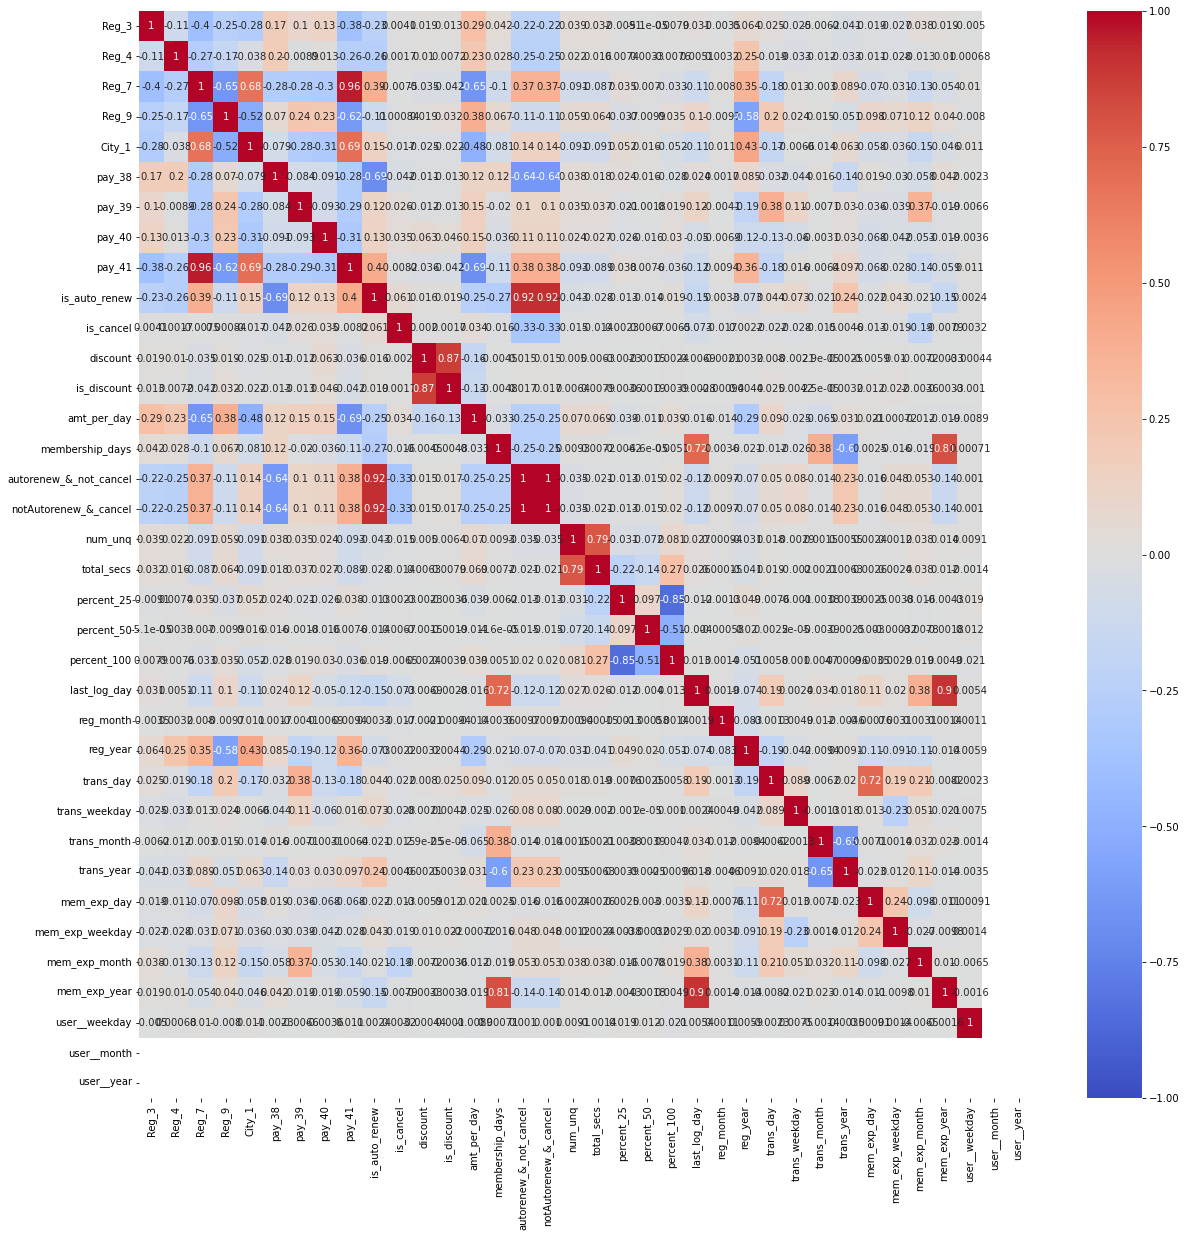

In [114]:
# Initial correlation visualization 
plt.figure(figsize=(20,20))
sns.heatmap(corr_clean_data.corr(), vmin=-1 , vmax=1 , cmap='coolwarm', annot=True)
plt.show()

Howcome we do not see any correlation values for `user__month` and `user__year`? Let's calcualte the correlations:

In [141]:
corr_clean_data['user__month'].corr(corr_clean_data['Reg_3'],method='pearson')  

nan

Since we get back NaN, this means that `user__month` and `user__year` are not correlated with any of the features. This is good for us as we are trying to remove any features that introduce multicollinearity. We can keep `user__month` and `user__year`. 

**There are some very obvious correlated features. These include:**
- `num_unq` and `total_secs`: 0.79
- `mem_exp_year` and `mem_exp_day` : 0.81
- `mem_exp_year` and `last_log_day` : 0.9
- `last_log_day` and `membership_days`: 0.72
- `autorenew_&_not_cancel` and `notAutorenew_&_cancel`: 1
- `notAutorenew_&_cancel` and `is_auto_renew`: 0.92
- `autorenew_&_not_cancel` and `is_auto_renew`: 0.92
- `discount` and `is_discoount`: 0.87

For the first decision, we will choose to remove `num_unq` since the total seconds gives us better information over the unique number of songs.

Since both `last_log_day` and `mem_exp_year` are strongly correlated with each other and with other features, we will drop both. 

Since `autorenew_&_not_cancel` is strongly correlated with `notAutorenew_&_cancel` and `is_auto_renew`, we will drop it. We will also drop `is_auto_renew` as it is stronly correlated with `notAutorenew_&_cancel` and we can get better information from `notAutorenew_&_cancel` as it would tell us about members who did not auto-renew their subscriptions and for sure also cancelled whereas `is_auto_renew` only tells us whether or not they auto-renewed.

Between `discount` and `is_discount`, we will remove `discount` as we care more about whether a member was offered a discount vs. the amount of the discount. 

**It is difficult to read the values off the heatmap so let's investigate the exact correlation values here:**

Beginning with the song percentages from User Logs,

In [118]:
corr_clean_data['percent_100'].corr(corr_clean_data['percent_25'],method='pearson')  

-0.8491732338131456

In [119]:
corr_clean_data['percent_100'].corr(corr_clean_data['percent_50'],method='pearson')  

-0.5067289346666342

In [123]:
corr_clean_data['percent_25'].corr(corr_clean_data['percent_50'],method='pearson')  

0.09698467480963827

We see that `percent_25` and `percent_50` are not strongly correlated while they are each strongly correlated with `percent_100`, so for now we will remove `percent_100`.

Now let's see what is going on with the payment methods (38,39,40,41), the registration types (3,4,7,9), `City_1`, and the transaction dates:

In [120]:
corr_clean_data['pay_41'].corr(corr_clean_data['City_1'],method='pearson')  

0.694282485378523

In [121]:
corr_clean_data['pay_41'].corr(corr_clean_data['Reg_7'],method='pearson')  

0.9576454915319784

In [122]:
corr_clean_data['Reg_7'].corr(corr_clean_data['City_1'],method='pearson')  

0.6765993376026377

In [133]:
corr_clean_data['Reg_7'].corr(corr_clean_data['amt_per_day'],method='pearson')  

-0.6536278816119307

In [158]:
corr_clean_data['Reg_9'].corr(corr_clean_data['reg_year'],method='pearson')  

-0.5827366688890114

In [157]:
corr_clean_data['notAutorenew_&_cancel'].corr(corr_clean_data['pay_38'],method='pearson')  

-0.6385699859457384

Thus, we will remove `pay_41`, `City_1`, `Reg_7`, `reg_year`, and `pay_38`.

In [124]:
corr_clean_data['trans_year'].corr(corr_clean_data['membership_days'],method='pearson')  

-0.5977356926723669

In [125]:
corr_clean_data['trans_year'].corr(corr_clean_data['trans_month'],method='pearson')  

-0.6531966057701731

Thus we will remove `trans_year`.

In [132]:
corr_clean_data['trans_day'].corr(corr_clean_data['mem_exp_day'],method='pearson')  

0.7197865109699467

Thus we will remove `trans_day`.

Let's drop these features in a new dataframe called `selected_clean_data`:

In [159]:
selected_clean_data = corr_clean_data.drop(
    ['num_unq', 
     'percent_100', 
     'mem_exp_year',
     'last_log_day',
     'autorenew_&_not_cancel',
     'is_auto_renew',
     'discount',
     'pay_41',
     'City_1',
     'Reg_7',
     'pay_38',
     'reg_year',
     'trans_year',
     'trans_day'
    ], 
    axis=1
)

In [162]:
# sanity check: verifying shape of new dataframe
selected_clean_data.shape

(754532, 23)

We still have 754,532 rows and have successfully dropped 14 features from 37 down to 23 columns. 

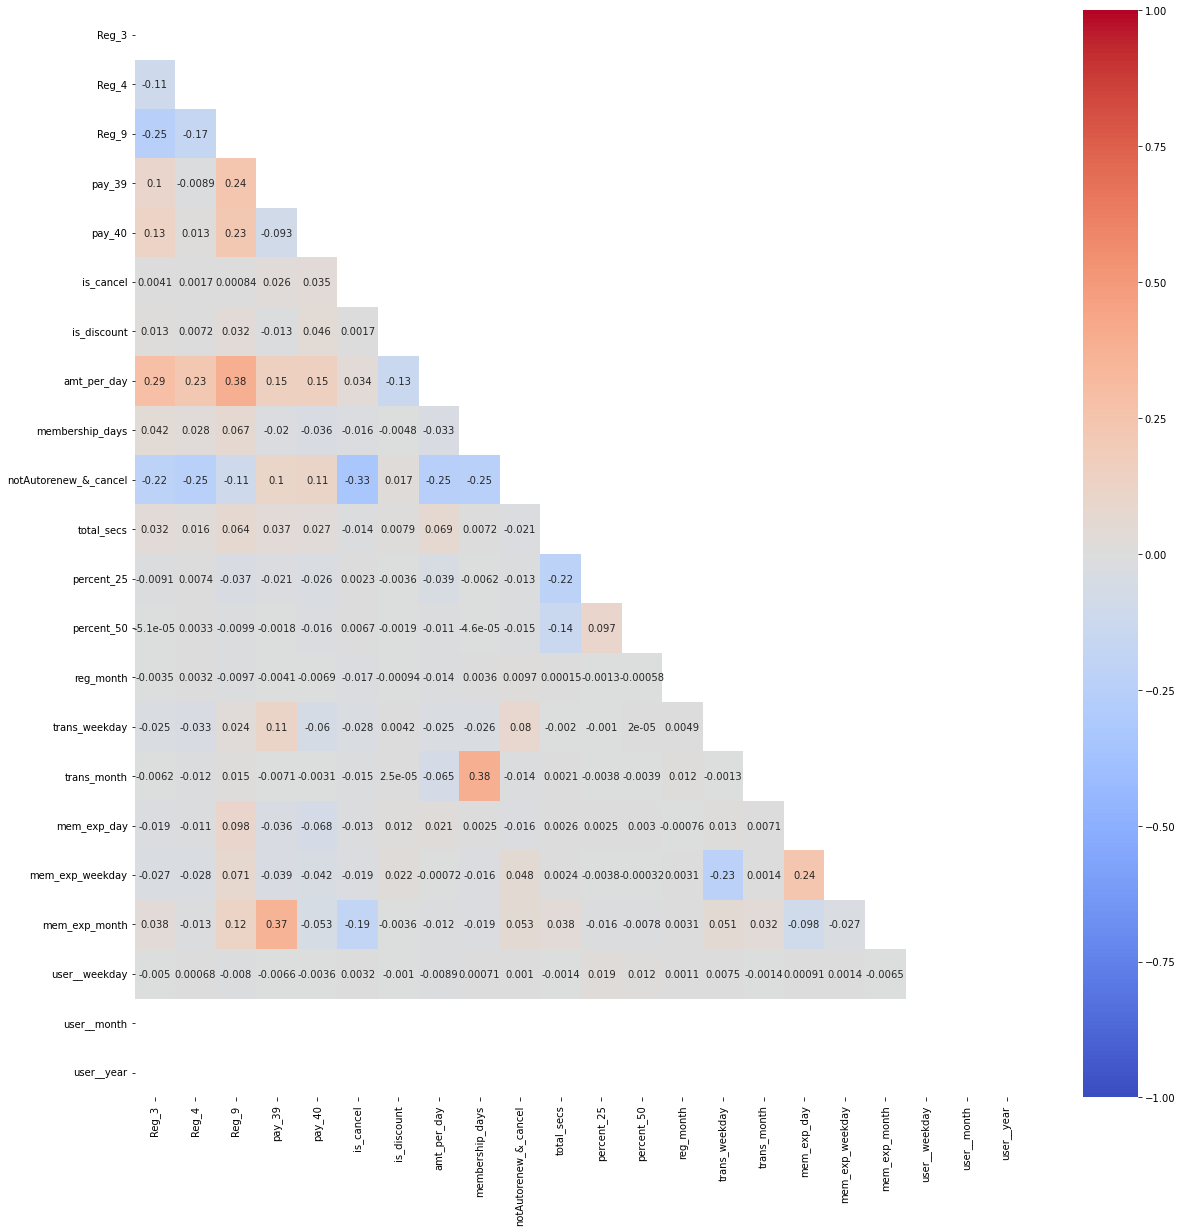

In [160]:
# Final correlation visualization
plt.figure(figsize=(20,20))
sns.heatmap(selected_clean_data.corr(), vmin=-1 , vmax=1 , cmap='coolwarm', annot=True, mask=np.triu(selected_clean_data.corr()))
plt.show()

We have improved our heatmap! There is still some multicollinearity between
- `amt_per_day` and `Reg_9` : 0.38
- `mem_exp_month` and `pay_39` : 0.37
- `trans_month` and `membership_days`: 0.38

But, since these values are all 0.38 we should be safe to keep these features. 

---

Final clean dataset with multicollinearity features removed, and `is_churn` included (to be used in next notebook for splitting into train and test sets):

In [165]:
sel_data = clean_data.drop(
    ['num_unq', 
     'percent_100', 
     'mem_exp_year',
     'last_log_day',
     'autorenew_&_not_cancel',
     'is_auto_renew',
     'discount',
     'pay_41',
     'City_1',
     'Reg_7',
     'pay_38',
     'reg_year',
     'trans_year',
     'trans_day'
    ], 
    axis=1
)

In [167]:
sel_data.columns

Index(['Reg_3', 'Reg_4', 'Reg_9', 'pay_39', 'pay_40', 'msno', 'is_churn',
       'is_cancel', 'is_discount', 'amt_per_day', 'membership_days',
       'notAutorenew_&_cancel', 'total_secs', 'percent_25', 'percent_50',
       'reg_month', 'trans_weekday', 'trans_month', 'mem_exp_day',
       'mem_exp_weekday', 'mem_exp_month', 'user__weekday', 'user__month',
       'user__year'],
      dtype='object')

In [168]:
sel_data.shape

(754532, 24)

---

### Saving and Exporting Final Clean Datasets

We will preserve our final clean datasets to use in the next notebooks by pickling them.

In [115]:
# clean data includes all features
clean_data.to_pickle('clean_data.pkl')

In [161]:
#selected_clean_data.to_pickle('selected_clean_data.pkl')

In [169]:
# new dataframe with selected features (removed multicollinearity, and contains target `is_churn`)
sel_data.to_pickle('sel_data.pkl')